<a href="https://colab.research.google.com/github/rhyhyr/dau/blob/main/MLP_%EA%B8%B0%EB%B0%98_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 패키지 선언

In [13]:
import torch
import numpy as np
import torch.nn as nn # 파이토치 안에서 뉴럴네트워크
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader

In [14]:
from google.colab import drive
datasetPath = "./drive/MyDrive/dataset/"
parameterPath = "./drive/MyDrive/parameters/"

## Dataset 선언

In [15]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = datasetPath, # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = datasetPath,
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

Files already downloaded and verified
Files already downloaded and verified


## MNIST 데이터셋 형상 확인

50000
torch.Size([3, 32, 32])
6


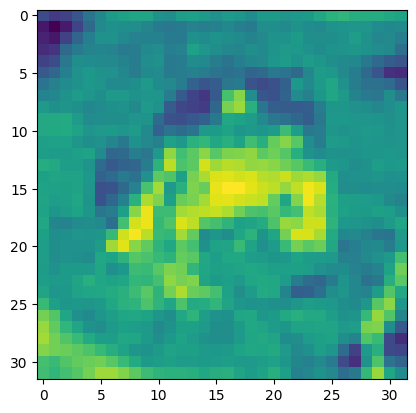

In [16]:
import matplotlib.pyplot as plt
print(len(cifar10_train))     # training dataset 개수 확인

first_data = cifar10_train[0]
print(first_data[0].shape)  # 첫번째 data의 형상 확인
print(first_data[1])        # 첫번째 data의 정답 확인

plt.imshow(first_data[0][0,:,:])
plt.show()

In [17]:
first_img = first_data[0]
print(first_img.shape)

first_img = first_img.view(-1, 32*32*3) # 이미지 평탄화 수행 2D -> 1D
print(first_img.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3072])


## Multi Layer Perceptron 모델 정의

In [19]:
# Multi Layer Perceptron 코드 작성
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()  # nn.Module의 모든 것을 가져오겠다
    self.fc1 = nn.Linear(in_features= 3072, out_features=2000)  # MLP할때 W 어쩌고 계산...
    self.bn = nn.BatchNorm1d(2000)
    self.fc2 = nn.Linear(in_features= 2000, out_features=1000)
    self.bn = nn.BatchNorm1d(1000)
    self.fc3 = nn.Linear(in_features= 1000, out_features=500)
    self.bn = nn.BatchNorm1d(500)
    self.fc4 = nn.Linear(in_features= 500, out_features=300)
    self.bn = nn.BatchNorm1d(300)
    self.fc5 = nn.Linear(in_features= 300, out_features=150)
    self.bn = nn.BatchNorm1d(150)
    self.fc6 = nn.Linear(in_features= 150, out_features=10)
    self.ReLU = nn.ReLU()
    self.dropout = nn.Dropout(0.2)

    torch.nn.init.xavier_normal_(self.fc1.weight.data)
    torch.nn.init.xavier_normal_(self.fc2.weight.data)
    torch.nn.init.xavier_normal_(self.fc3.weight.data)
    torch.nn.init.xavier_normal_(self.fc4.weight.data)
    torch.nn.init.xavier_normal_(self.fc5.weight.data)


  def forward(self,x):
    x = x.view(-1, 32*32*3)  # 이미지 평탄화
    y = self.ReLU(self.bn(self.fc1(x)))
    y = self.ReLU(self.bn(self.fc2(y)))
    y = self.ReLU(self.bn(self.fc3(y)))
    y = self.ReLU(self.bn(self.fc4(y)))
    y = self.ReLU(self.bn(self.fc5(y)))
    y = self.dropout(y)
    y = self.fc6(y)
    return y

## Hyper-parameters 지정

In [21]:
batch_size = 200
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = MLP()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10], gamma=0.1)

data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## Perceptron 학습을 위한 반복문 선언

In [22]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
      pred = network(img)

      loss = loss_function(pred, label)
      optimizer.zero_grad() # gradient 초기화
      loss.backward()
      optimizer.step()

      avg_cost += loss / total_batch
  scheduler.step()
  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

RuntimeError: running_mean should contain 2000 elements not 150

## 학습이 완료된 모델을 이용해 정답률 확인

In [ ]:
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data,(0,3,1,2))) / 255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.4733000099658966


## Weight parameter 저장하기/불러오기

In [ ]:
torch.save(network.state_dict(), "./mlp_mnist.pth")